In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import math

from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MultiLabelBinarizer, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest, f_regression

import warnings
warnings.filterwarnings('ignore')

import ast
from collections import Counter


from numpy import unique
from scipy.stats import skew

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# Define file paths
TRAINING_DATA = '../../data/preprocessed/train.parquet'
VALIDATION_DATA = '../../data/preprocessed/validation.parquet'
TESTING_DATA = '../../data/preprocessed/test.parquet'

df_train = pd.read_parquet(TRAINING_DATA)
df_validation = pd.read_parquet(VALIDATION_DATA)
df_small_test = pd.read_parquet(TESTING_DATA)
df_test = pd.concat([df_validation,df_small_test],axis = 0).reset_index(drop=True)

In [ ]:
df_train.columns
#pd.set_option('display.max_rows', 50)
#pd.set_option('display.max_columns', None)
#df_train['copiesSold']

Index(['steam_achievements', 'steam_trading_cards', 'workshop_support',
       'achievements_total', 'is_release_date_known', 'is_upcoming', 'year',
       'sin_day', 'cos_day', 'price', 'reviewScore', 'has_demo', 'demo_count',
       'has_dlc', 'dlc_count', 'copiesSold', 'metacritic_preprocessed',
       'has_metacritic', 'genre_Action', 'genre_Adventure', 'genre_Casual',
       'genre_Early Access', 'genre_Free To Play', 'genre_Gore', 'genre_Indie',
       'genre_Massively Multiplayer', 'genre_Nudity', 'genre_Other',
       'genre_RPG', 'genre_Racing', 'genre_Sexual Content', 'genre_Simulation',
       'genre_Sports', 'genre_Strategy', 'genre_Violent', 'platform_linux',
       'platform_mac', 'platform_windows', 'name_len', 'name_words',
       'name_cap_ratio', 'is_sequel', 'name_has_vr', 'name_has_remaster',
       'name_has_collector', 'name_has_collection', 'name_has_edition',
       'name_has_bundle', 'name_has_playtest', 'publisherClass_Indie',
       'publisherClass_Other'],
 

In [ ]:
X_train = df_train.copy()
y_train = df_train['copiesSold'].copy()

X_test = df_test.copy()
y_test = df_test['copiesSold'].copy()

X_train.drop('copiesSold',axis=1,inplace=True)
X_test.drop('copiesSold',axis=1,inplace=True)
X_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13885 entries, 0 to 13884
Data columns (total 50 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   steam_achievements           13885 non-null  int64  
 1   steam_trading_cards          13885 non-null  int64  
 2   workshop_support             13885 non-null  int64  
 3   achievements_total           13885 non-null  float64
 4   is_release_date_known        13885 non-null  int64  
 5   is_upcoming                  13885 non-null  float64
 6   year                         13885 non-null  int64  
 7   sin_day                      13885 non-null  float64
 8   cos_day                      13885 non-null  float64
 9   price                        13885 non-null  float64
 10  reviewScore                  13885 non-null  float64
 11  has_demo                     13885 non-null  int64  
 12  demo_count                   13885 non-null  int64  
 13  has_dlc         

Function for plotting R^2,MSE,MAE

In [ ]:
def plot_r_square(r2_scores,labelName):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, X_train.shape[1] + 1), r2_scores, marker='o', color='darkred',label=labelName)
    plt.title("R² Score vs Number of Selected Features")
    plt.xlabel("Number of Top Features Selected")
    plt.ylabel("R² Score")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_mse(mse_vals,labelName):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, X_train.shape[1] + 1), mse_vals, marker='o', color='darkgreen',label=labelName)
    plt.title("Mean Square Error vs Number of Selected Features")
    plt.xlabel("Number of Top Features Selected")
    plt.ylabel("MSE Score")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_mae(mae_vals,labelName):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, X_train.shape[1] + 1), mae_vals, marker='o', color='darkblue',label=labelName)
    plt.title("Mean Absoulte Error vs Number of Selected Features")
    plt.xlabel("Number of Top Features Selected")
    plt.ylabel("MAE Score")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

Get Number of features used to get highest R^2 and lowest MAE and MSE



In [ ]:
def evaluate(r2_scores,mse_vals,mae_vals):
    max_r2 = max(r2_scores)
    best_index_r2 = r2_scores.index(max_r2)

    min_mse = min(mse_vals)
    best_index_mse = mse_vals.index(min_mse)

    min_mae = min(mae_vals)
    best_index_mae = mae_vals.index(min_mae)
    
    print(f"Max R² = {max_r2:.4f} at {best_index_r2 + 1} features \nMIN MSE = {min_mse:.4f} at {best_index_mse + 1} features \nMIN MAE = {min_mae:.4f} at {best_index_mae + 1} features \n")
    

**K best features using Mutual information feature selection method**

What do mutual information scores mean?
Each score represents how much information a feature gives about the target(output) variable.

Higher score : more useful the feature is for predicting the target.

Lower score (close to 0) : not informative, maybe noise or irrelevant.

mutual_info_regression works with numerical and categorical features
but It assumes numerical input only.

In [10]:
X_train.drop(columns=['name_len','name_words','has_demo','has_dlc','has_metacritic','name_cap_ratio'],inplace=True)
X_test.drop(columns=['name_len','name_words','has_demo','has_dlc','has_metacritic','name_cap_ratio'],inplace=True)


In [ ]:
# Output (Target) : Numerical (Continuous) --> Regression 
# Input features : Both numerical and categorcal

selector = SelectKBest(mutual_info_regression, k='all')
selector.fit(X_train, y_train)

# Get scores (information of each feature)
mi_scores = selector.scores_

# Combine feature names with scores
feature_scores = list(zip(X_train.columns, mi_scores))

# Sort by information score in descending order
sorted_scores = sorted(feature_scores, key=lambda x: x[1], reverse=True)

for feature, score in sorted_scores:
    print(f"{feature}: {score:.4f}")

reviewScore: 0.4314
year: 0.2186
price: 0.1835
publisherClass_Indie: 0.1448
achievements_total: 0.0818
metacritic_preprocessed: 0.0675
publisherClass_Other: 0.0628
genre_Free To Play: 0.0545
steam_trading_cards: 0.0323
steam_achievements: 0.0193
cos_day: 0.0179
dlc_count: 0.0154
sin_day: 0.0147
is_sequel: 0.0125
is_upcoming: 0.0120
genre_Casual: 0.0117
genre_Indie: 0.0102
genre_Massively Multiplayer: 0.0100
genre_RPG: 0.0081
genre_Simulation: 0.0073
workshop_support: 0.0072
is_release_date_known: 0.0059
platform_linux: 0.0048
platform_mac: 0.0046
genre_Sports: 0.0037
genre_Action: 0.0032
genre_Racing: 0.0028
demo_count: 0.0022
genre_Strategy: 0.0019
name_has_vr: 0.0010
name_has_remaster: 0.0004
genre_Other: 0.0002
name_has_edition: 0.0002
genre_Adventure: 0.0000
genre_Early Access: 0.0000
genre_Gore: 0.0000
genre_Nudity: 0.0000
genre_Sexual Content: 0.0000
genre_Violent: 0.0000
platform_windows: 0.0000
name_has_collector: 0.0000
name_has_collection: 0.0000
name_has_bundle: 0.0000
name_

Plotting

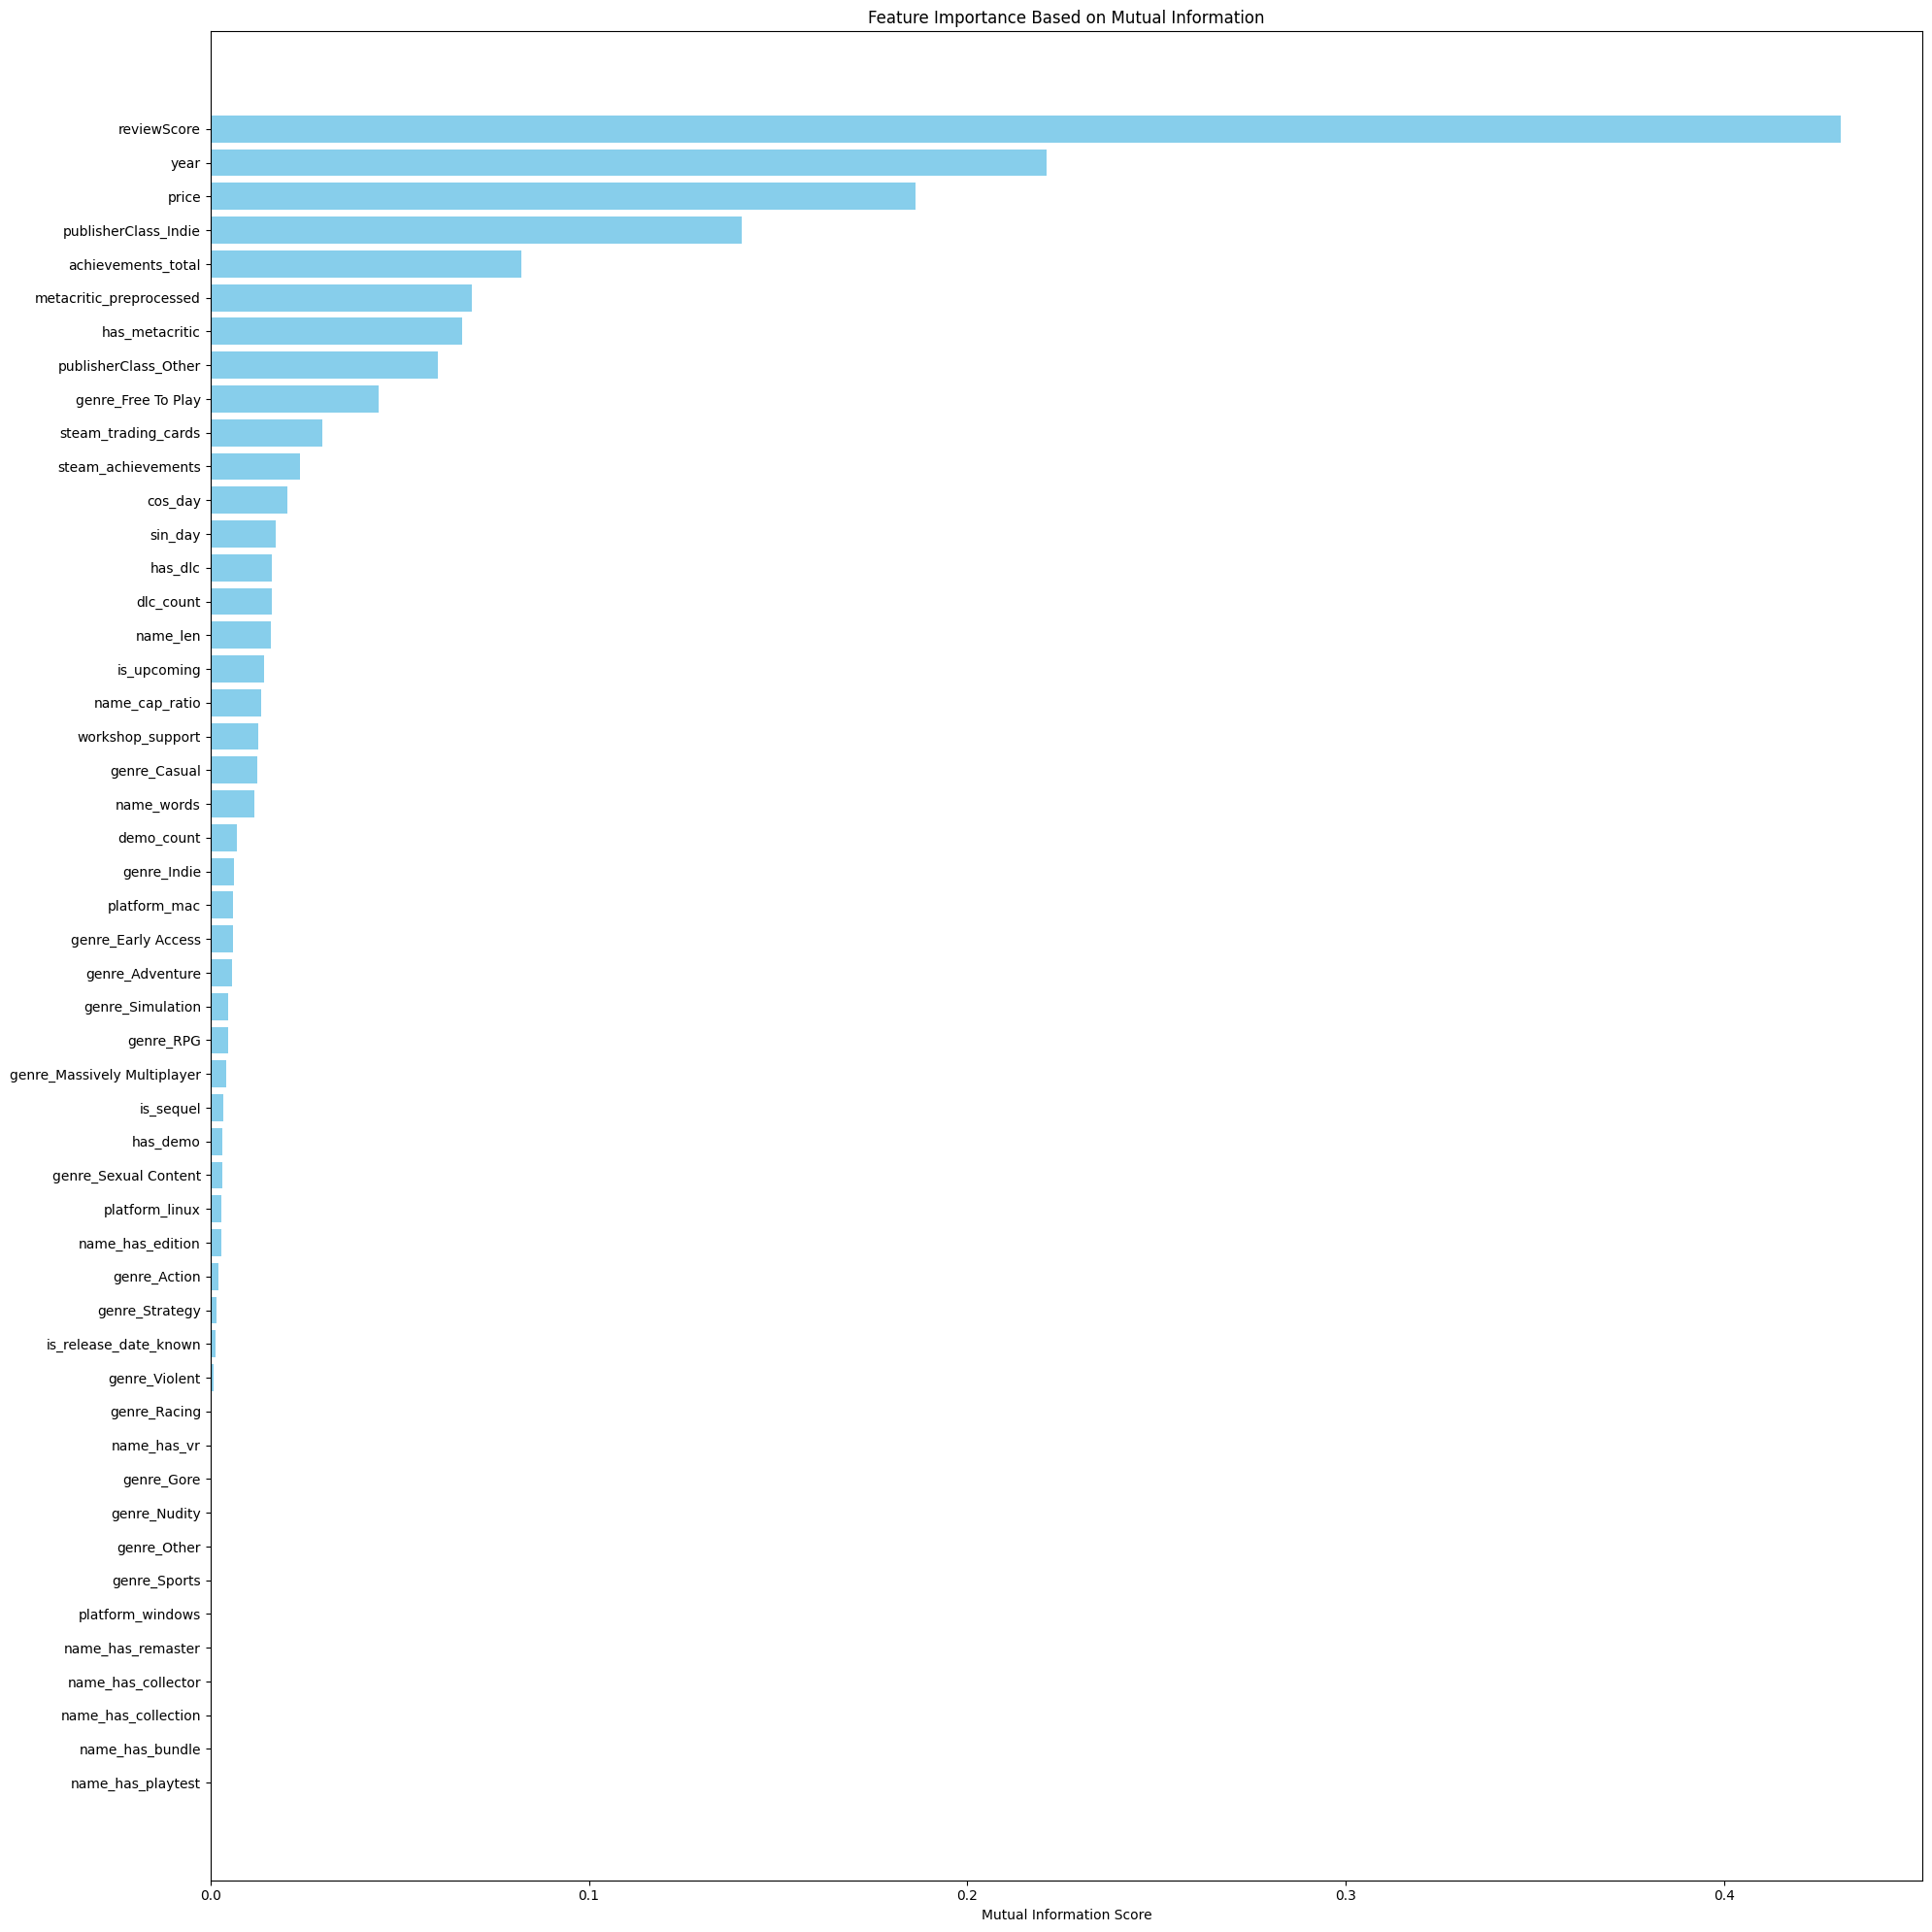

In [ ]:
# Unzip to plot meaning we will seperate features and scores
featuress, scores = zip(*sorted_scores)

# Plotting
plt.figure(figsize=(20, 20))
plt.barh(featuress, scores, color='skyblue')
plt.xlabel("Mutual Information Score")
plt.title("Feature Importance Based on Mutual Information")
plt.gca().invert_yaxis()  # Highest scores on top
plt.tight_layout()
plt.show()

## Gradient Boosting model
try different number of top k features

In [ ]:
r2_scores = []
mse = []
mae = []
for i in range(1,X_train.shape[1] + 1):
    gbr = GradientBoostingRegressor(max_depth=5,random_state=42)
    selector = SelectKBest(mutual_info_regression,k=i)
    selector.fit(X_train,y_train)

    sel_x_train = selector.transform(X_train)
    sel_x_test = selector.transform(X_test)

    gbr.fit(sel_x_train,y_train)
    y_pred = gbr.predict(sel_x_test)
    
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)
    mse.append(mean_squared_error(y_test,y_pred))
    mae.append(mean_absolute_error(y_test,y_pred))
    
    
    

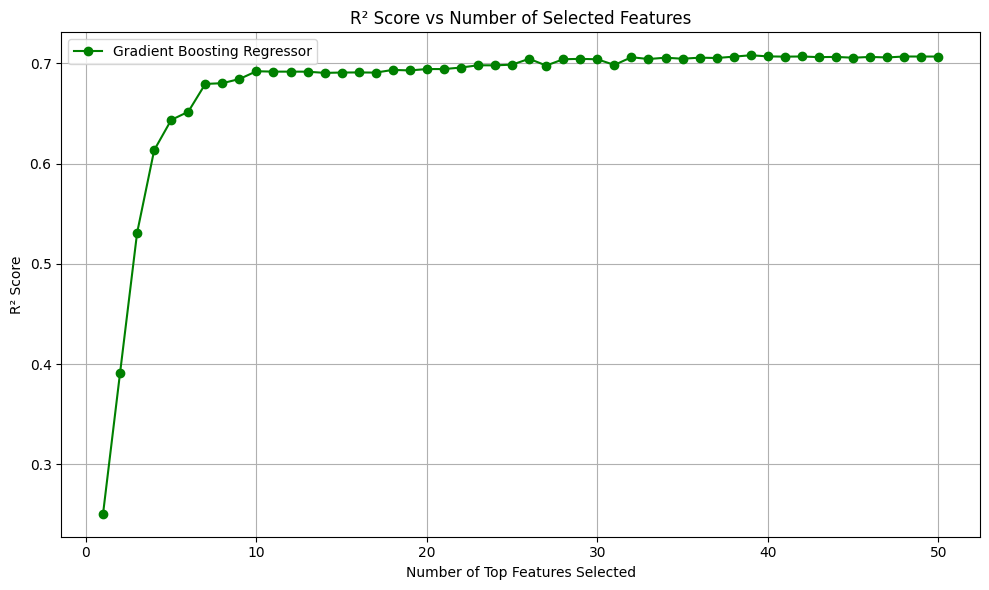

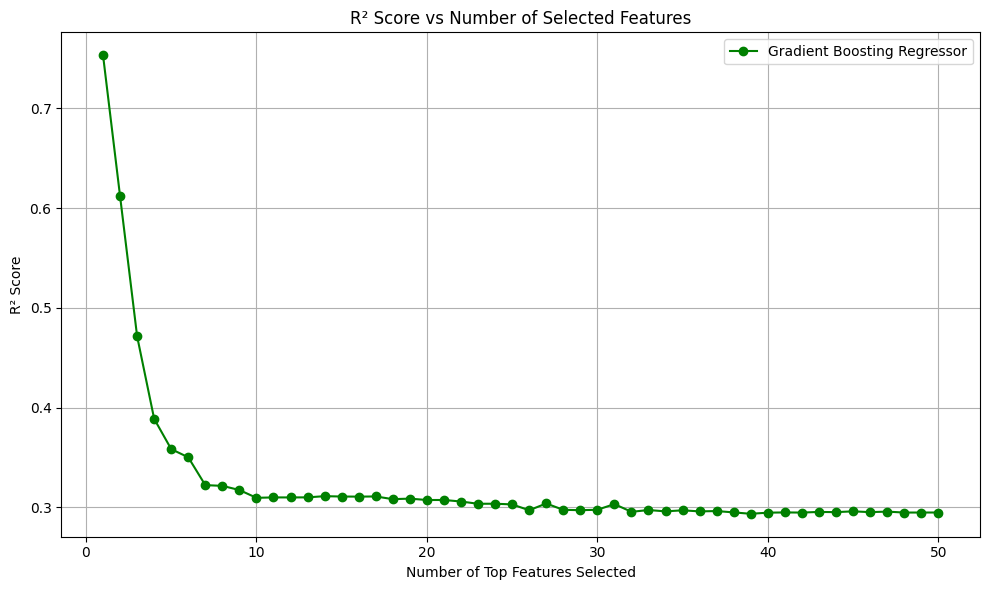

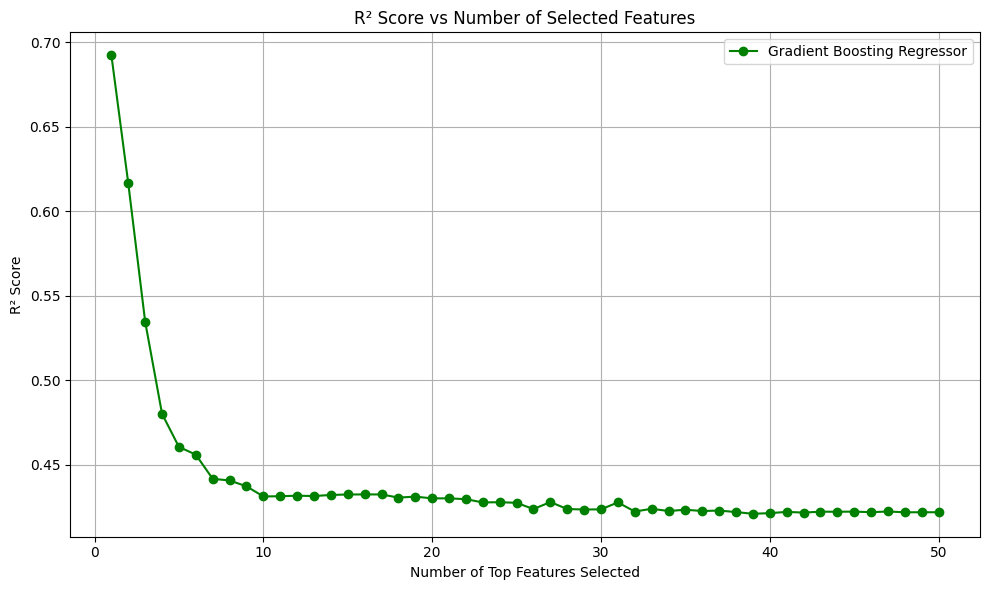

Max R² = 0.7079 at 39 features 
 MIN MSE = 0.2936 at 39 features 
 MIN MAE = 0.4209 at 39 features 



In [8]:
plot_r_square(r2_scores,"Gradient Boosting Regressor")
plot_mse(mse,"Gradient Boosting Regressor")
plot_mae(mae,"Gradient Boosting Regressor")

evaluate(r2_scores,mse,mae)

In [ ]:
r2_scores

## Decision Tree Regressor 


In [ ]:
r2_scores_ID3 = []
mse_ID3 = []
mae_ID3 = []
for i in range(1,X_train.shape[1] + 1):
    model_ID3 = DecisionTreeRegressor()
    selector = SelectKBest(mutual_info_regression,k=i)
    selector.fit(X_train,y_train)

    sel_x_train = selector.transform(X_train)
    sel_x_test = selector.transform(X_test)

    model_ID3.fit(sel_x_train, y_train)
    y_pred = model_ID3.predict(sel_x_test)

     
    r2 = r2_score(y_test, y_pred)
    r2_scores_ID3.append(r2)

    mse_ID3.append(mean_squared_error(y_test,y_pred))
    mae_ID3.append(mean_absolute_error(y_test,y_pred))

Plotting 

In [ ]:
plot_r_square(r2_scores_ID3,"Decision Tree Regressor")
plot_mse(mse_ID3,"Decision Tree Regressor")
plot_mae(mae_ID3,"Decision Tree Regressor")

evaluate(r2_scores_ID3,mse_ID3,mae_ID3)

In [ ]:
r2_scores_ID3

Gradient Boosting variants : XGBoost, LightGBM, CatBoost

In [ ]:
r2_scores_XGBOOST = []
r2_scores_LGBM = []
r2_scores_CatBoost = []

mse_XGBOOST = []
mae_XGBOOST = []

mse_LGBM = []
mae_LGBM = []

mse_CatBoost = []
mae_CatBoost = []

for i in range(1,X_train.shape[1] + 1):
    model_XGB = XGBRegressor(random_state=42)
    model_LGBM = LGBMRegressor(random_state=42)
    model_CatBoost = CatBoostRegressor(verbose=0, random_state=42)

    selector = SelectKBest(mutual_info_regression,k=i)
    selector.fit(X_train,y_train)

    sel_x_train = selector.transform(X_train)
    sel_x_test = selector.transform(X_test)

    # XGBoost
    model_XGB.fit(sel_x_train, y_train)
    y_pred = model_XGB.predict(sel_x_test)
    r2 = r2_score(y_test, y_pred)
    r2_scores_XGBOOST.append(r2)
    mse_XGBOOST.append(mean_squared_error(y_test,y_pred))
    mae_XGBOOST.append(mean_absolute_error(y_test,y_pred))

    # LightGBM
    model_LGBM.fit(sel_x_train, y_train)
    y_pred = model_LGBM.predict(sel_x_test)
    r2 = r2_score(y_test, y_pred)
    r2_scores_LGBM.append(r2)
    mse_LGBM.append(mean_squared_error(y_test,y_pred))
    mae_LGBM.append(mean_absolute_error(y_test,y_pred))

    #  CatBoost
    model_CatBoost.fit(sel_x_train, y_train)
    y_pred = model_CatBoost.predict(sel_x_test)
    r2 = r2_score(y_test, y_pred)
    r2_scores_CatBoost.append(r2)
    mse_CatBoost.append(mean_squared_error(y_test,y_pred))
    mae_CatBoost.append(mean_absolute_error(y_test,y_pred))

    

Plotting for XGBOOST

In [ ]:
plot_r_square(r2_scores_XGBOOST,"XGBOOST Regressor")
plot_mse(mse_XGBOOST,"XGBOOST Regressor")
plot_mae(mae_XGBOOST,"XGBOOST Regressor")

evaluate(r2_scores_XGBOOST,mse_XGBOOST,mae_XGBOOST)

Plotting for LightGBM

In [ ]:
plot_r_square(r2_scores_LGBM,"LightGBM Regressor")
plot_mse(mse_LGBM,"LightGBM Regressor")
plot_mae(mae_LGBM,"LightGBM Regressor")

evaluate(r2_scores_LGBM,mse_LGBM,mae_LGBM)

Plotting for  CatBoost

In [ ]:
plot_r_square(r2_scores_CatBoost,"CatBoost Regressor")
plot_mse(mse_CatBoost,"CatBoost Regressor")
plot_mae(mae_CatBoost,"CatBoost Regressor")

evaluate(r2_scores_CatBoost,mse_CatBoost,mae_CatBoost)

In [ ]:
r2_scores_CatBoost